In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from bblab_challenge import load_mask, load_layer, apply_mask, get_rgba, prepare_image

mask = load_mask('./data/single-cell-mask/single_cell_mask.tiff')
image_height, image_width = mask.shape
red = load_layer('./data/images/Fibronectin(Dy163Di).tiff', image_width, image_height)
green = load_layer('./data/images/E-cadherin(Er167Di).tiff', image_width, image_height)
blue = load_layer('./data/images/HistoneH3(Yb176Di).tiff', image_width, image_height)

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex='all', sharey='all')
ax = axes.ravel()

ax[0].imshow(red, cmap='Reds')
ax[0].set_title("Red")

ax[1].imshow(green, cmap='Greens')
ax[1].set_title("Green")

ax[2].imshow(blue, cmap='Blues')
ax[2].set_title("Blue")

ax[3].imshow(mask, cmap='gray')
ax[3].set_title("Mask")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

ImportError: cannot import name 'load_mask'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


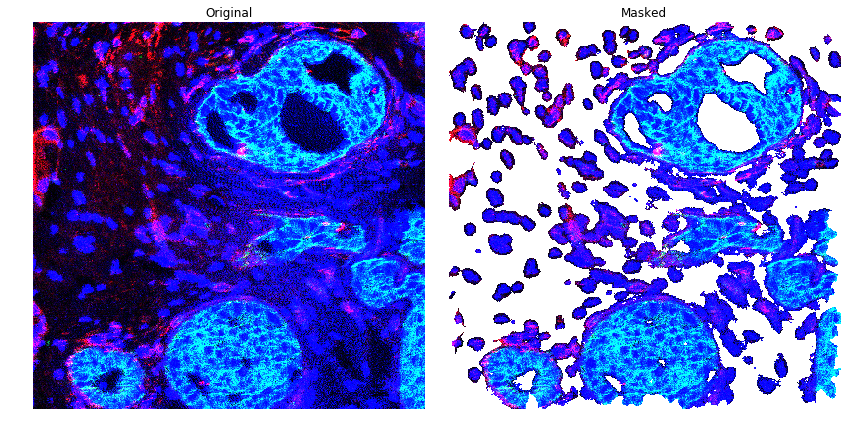

In [3]:
rgba = get_rgba(red, green, blue, 5.0, 5.0, 5.0)
masked_rgba = apply_mask(rgba, mask)

fig, axes = plt.subplots(1, 2, figsize=(12, 12), sharex='all', sharey='all')
ax = axes.ravel()

ax[0].imshow(rgba.astype(np.uint16))
ax[0].set_title("Original")

ax[1].imshow(masked_rgba.astype(np.uint16))
ax[1].set_title("Masked")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

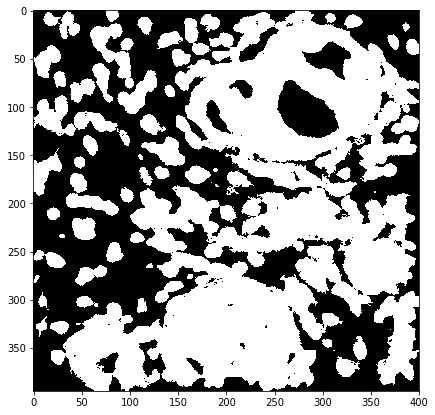

In [4]:
inverted_mask = cv.bitwise_not(mask.copy())
ret, thresh = cv.threshold(inverted_mask, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
plt.figure(figsize=(7, 7))
plt.imshow(thresh, cmap='gray')

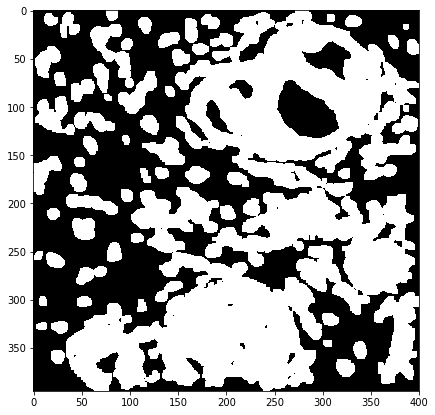

In [5]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)
plt.figure(figsize=(7, 7))
plt.imshow(opening, cmap='gray')

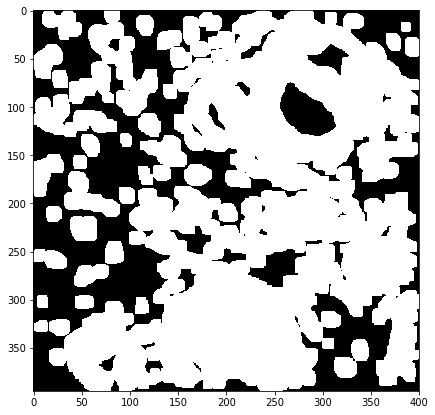

In [6]:
# sure background area
sure_bg = cv.dilate(opening, kernel, iterations=2)
plt.figure(figsize=(7, 7))
plt.imshow(sure_bg, cmap='gray')

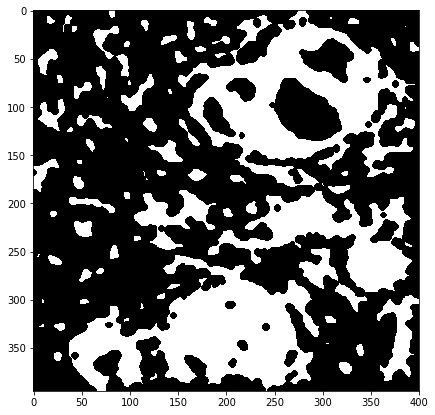

In [7]:
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
ret, sure_fg = cv.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)
plt.figure(figsize=(7, 7))
plt.imshow(sure_fg, cmap='gray')

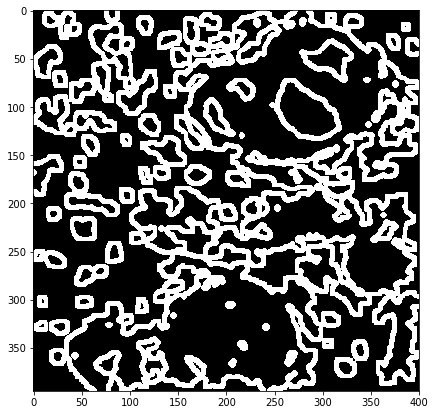

In [8]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)
plt.figure(figsize=(7, 7))
plt.imshow(unknown, cmap='gray')


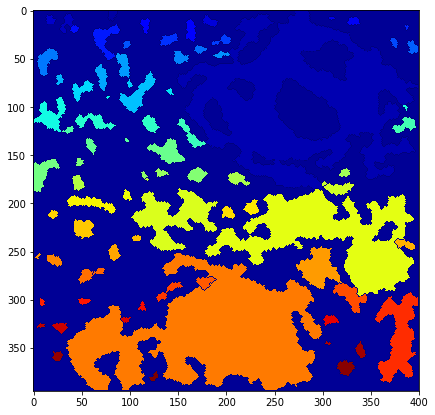

In [13]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1
# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

img = prepare_image(masked_rgba, mask)
markers = cv.watershed(img, markers)
plt.figure(figsize=(7, 7))
plt.imshow(markers, cmap='jet')

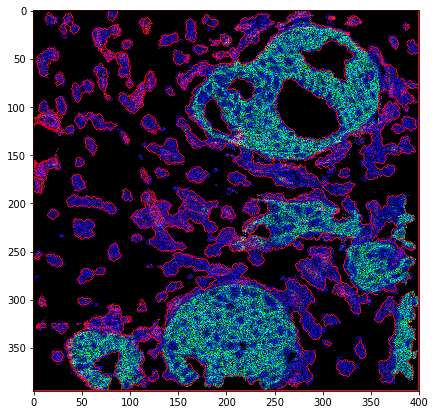

In [14]:
img[markers == -1] = [255, 0, 0]
plt.figure(figsize=(7, 7))
plt.imshow(img)